In [1]:
import tensorflow as tf
print(tf.__version__)

import sys
print(sys.version)

2.17.0
3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, AdamW
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data from CSV
df = pd.read_csv('HurriData.csv')

# Assume the CSV has columns: timestamp, wind_speed, pressure, latitude, longitude, radius
# And we want to predict the next latitude and longitude

# Sort the dataframe by timestamp
df = df.sort_values(axis=0,by=['name','year','month','day'])

In [3]:
# Let's clean the data by handling the NaN values and ensuring all relevant columns are ready for model input.
# We'll fill NaN values with appropriate strategies (e.g., forward fill for continuity or filling with mean values for wind and pressure).

# Dropping the 'Unnamed: 0', 'name', 'year', 'month', 'day', 'hour', 'status', and 'category' columns since they're not needed for the model
df_cleaned = df.drop(columns=['Unnamed: 0', 'name', 'year', 'month', 'day', 'hour', 'status', 'category','tropicalstorm_force_diameter','hurricane_force_diameter'])

# Forward fill the latitude and longitude to maintain continuity
df_cleaned[['lat', 'long']] = df_cleaned[['lat', 'long']].fillna(method='ffill')

# Fill NaN values in 'wind' and 'pressure' with the mean of each column
df_cleaned['wind'].fillna(df_cleaned['wind'].mean(), inplace=True)
df_cleaned['pressure'].fillna(df_cleaned['pressure'].mean(), inplace=True)

# Fill NaN values in 'tropicalstorm_force_diameter' and 'hurricane_force_diameter' with 0 (assuming no force if NaN)
#df_cleaned['tropicalstorm_force_diameter'].fillna(0, inplace=True)
#df_cleaned['hurricane_force_diameter'].fillna(0, inplace=True)

# Display the first few rows of the cleaned data
df_cleaned.head()


C:\Users\Kenne\AppData\Local\Temp\ipykernel_37988\1072225810.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[['lat', 'long']] = df_cleaned[['lat', 'long']].fillna(method='ffill')
C:\Users\Kenne\AppData\Local\Temp\ipykernel_37988\1072225810.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['wind'].fillna(df_cleaned['wind'].mean(), inplace=True)
C:\Users\Kenne\AppData\Local\Temp\ipykernel_37988\1072225810.py:1

,lat,long,wind,pressure
4544,21.5,-84.0,25,1003
4545,22.3,-82.0,25,1002
4546,23.2,-80.3,25,1000
4547,24.5,-79.0,25,1000
4548,25.4,-77.5,30,999


In [4]:


# Create sequences of data
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data.iloc[i+seq_length][['lat', 'long']]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df[['wind', 'pressure', 'lat', 'long']])

# Create sequences
seq_length = 10  # 10 time steps of 6-hour intervals = 60 hours of data
X, y = create_sequences(pd.DataFrame(normalized_data, columns=['wind', 'pressure', 'lat', 'long']), seq_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(seq_length, 4), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(8, activation='softmax'),
    Dense(2)  # Output layer: predicted latitude and longitude
])

# Compile the model
model.compile(optimizer=AdamW(learning_rate=1e-4), loss='mse',metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
sample_data = X_test[:1]  # Take the first sequence from the test set
prediction = model.predict(sample_data)



c:\Users\Kenne\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5999 - loss: 0.0514 - val_accuracy: 0.7621 - val_loss: 0.0202
Epoch 2/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7797 - loss: 0.0204 - val_accuracy: 0.8035 - val_loss: 0.0152
Epoch 3/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8133 - loss: 0.0155 - val_accuracy: 0.8507 - val_loss: 0.0120
Epoch 4/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8398 - loss: 0.0124 - val_accuracy: 0.8610 - val_loss: 0.0099
Epoch 5/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8622 - loss: 0.0098 - val_accuracy: 0.8856 - val_loss: 0.0083
Epoch 6/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8811 - loss: 0.0089 - val_accuracy: 0.9056 - val_loss: 0.0072
Epoch 7/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8875 - loss: 0.0079 - val_accuracy: 0.9105 - val_loss: 0.0064
Epoch 8/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8925 - loss: 0.0068 - val_accu

In [5]:
print("Prediction shape:", prediction.shape)
print("Zeros (1, 3) shape:", np.zeros((1, 3)).shape)
print("Zeros (1, 1) shape:", np.zeros((1, 1)).shape)

Prediction shape: (1, 2)
Zeros (1, 3) shape: (1, 3)
Zeros (1, 1) shape: (1, 1)


In [6]:
sample_data = X_test[:1]  # Take the first sequence from the test set
prediction = model.predict(sample_data)

print("Prediction shape:", prediction.shape)
print("Zeros (1, 3) shape:", np.zeros((1, 3)).shape)
print("Zeros (1, 1) shape:", np.zeros((1, 1)).shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction shape: (1, 2)
Zeros (1, 3) shape: (1, 3)
Zeros (1, 1) shape: (1, 1)


In [7]:
# Assuming prediction shape is (1, 2) for lat and lon
prediction_padded = np.pad(prediction, ((0, 0), (2, 0)), mode='constant')
prediction_original_scale = scaler.inverse_transform(prediction_padded)[:, 2:4]

In [8]:
# Inverse transform the prediction to get actual latitude and longitude
#prediction_original_scale = scaler.inverse_transform(np.concatenate([np.zeros((1, 3)), prediction, np.zeros((1, 1))], axis=1))[:, 2:4]

print(f"Predicted next position (lat, lon): {prediction_original_scale[0]}")

Predicted next position (lat, lon): [ 36.36387 -65.73478]


In [9]:
import matplotlib.pyplot as plt

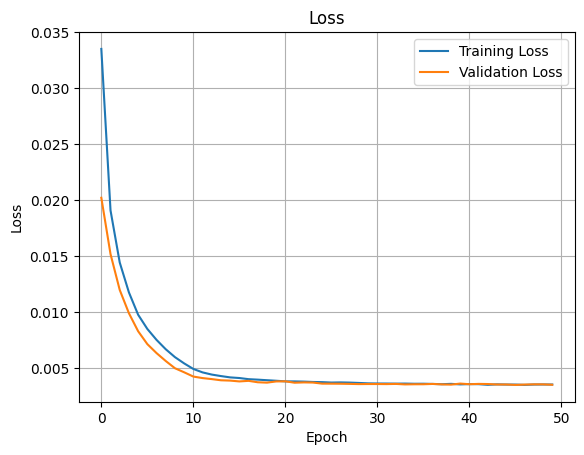

In [12]:
# Plot the loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.save('hurri_pred.h5')
